In [14]:
import numpy as np
import pandas as pd
from enum import Enum

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sklearn as sk
import sklearn.neighbors
import sklearn.cluster
import sklearn.tree

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
np.random.seed(42)
sns.set_palette('husl', 3)

In [4]:
df = sns.load_dataset("iris")

In [3]:
print(df.describe(), df.info(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000
Non

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
class Flour(Enum):
    SETOSA = 0
    VERSICOLOR = 1
    VIRGINICA = 2
    def __str__(self):
        return self.name

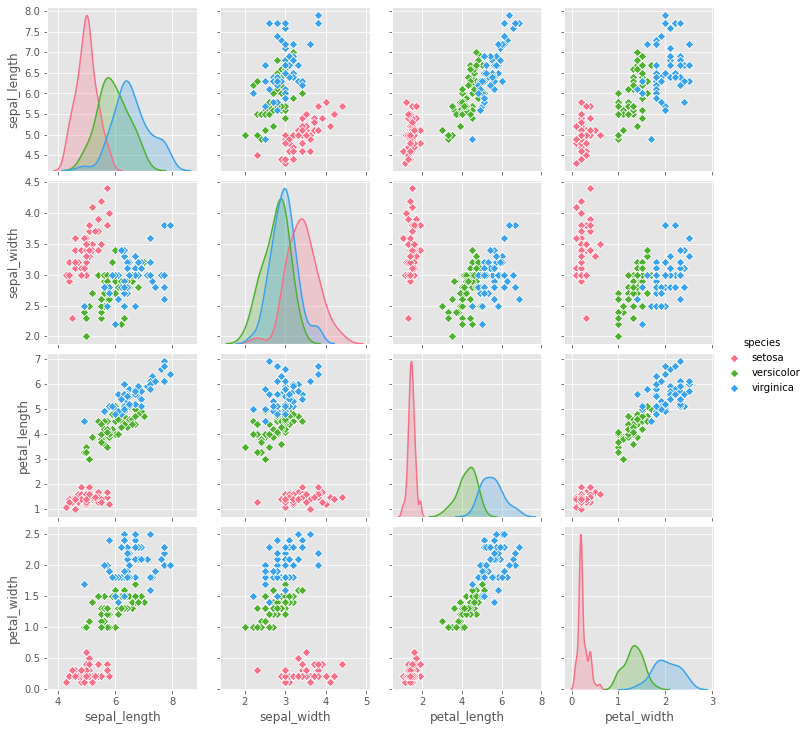

In [6]:
g = sns.pairplot(df, hue='species', markers='D', size=2.5)

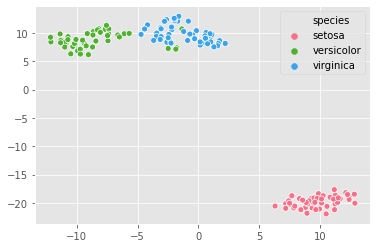

In [6]:
tsne = TSNE(learning_rate=100, random_state=42)
normalized = Normalizer(norm='max').fit_transform(df.drop('species', axis=1).values)
tsne_features = tsne.fit_transform(normalized)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
sns.scatterplot(xs, ys, hue=df.species)
plt.show()

In [25]:
y = df.species.apply(lambda x: getattr(Flour, x.upper()).value)
x = df.drop('species', axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

## KNN

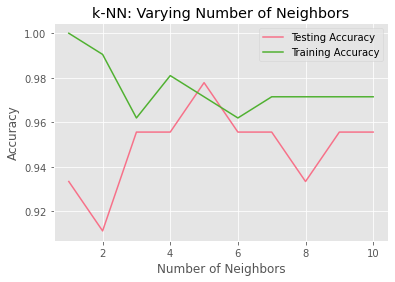

In [9]:
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    train_accuracy[i] = knn.score(x_train, y_train)
    test_accuracy[i] = knn.score(x_test, y_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()

In [10]:
param_grid = dict(n_neighbors=[i for i in range(11)])
est = sk.neighbors.KNeighborsClassifier()
grid_model = GridSearchCV(estimator=est, param_grid=param_grid, cv=5)
grid_model.fit(x_train, y_train)

best_score, best_params = grid_model.best_score_, grid_model.best_params_
print(f"Best: {best_score} \tusing {best_params}")

Best: 0.980952380952381 	using {'n_neighbors': 9}


In [11]:
knn_pred = grid_model.predict(x)
ctab_knn = pd.DataFrame({'labels' : knn_pred, 'varieties' : [str(Flour(i)) for i in y]})
pd.crosstab(ctab_knn.labels, ctab_knn.varieties)

varieties,SETOSA,VERSICOLOR,VIRGINICA
labels,,,
0,50,0,0
1,0,48,3
2,0,2,47


## K-means

In [34]:
kmeans = sk.cluster.KMeans(n_clusters=3)
norm = Normalizer(norm='max')
pipeline = make_pipeline(norm, kmeans)
pipeline.fit(x)
kmeans_pred = pipeline.predict(x)

ctab_kmeans = pd.DataFrame({'labels' : kmeans_pred, 'varieties' : [Flour(i).name for i in y]})
pd.crosstab(ctab_kmeans.labels, ctab_kmeans.varieties)

varieties,SETOSA,VERSICOLOR,VIRGINICA
labels,,,
0,50,0,0
1,0,46,0
2,0,4,50


## Tree

In [36]:
tree = sk.tree.DecisionTreeClassifier()
pl = make_pipeline(norm, tree)
pl.fit(x_train, y_train)
tree_pred = pl.predict(x_test)

ctab_tree = pd.DataFrame({'labels' : tree_pred, 'varieties' : [Flour(i).name for i in y_test]})
pd.crosstab(ctab_tree.labels, ctab_tree.varieties)

varieties,SETOSA,VERSICOLOR,VIRGINICA
labels,,,
0,15,0,0
1,0,15,3
2,0,0,12


OLS  
Ridge  
Lasso  
Elastic Net
KNN  
Logistic Regression  
decison tree  
SVM  
SVC  